In [39]:
import matplotlib.pyplot as plt
import numpy as np
import dolfin

In [138]:
# Create mesh and define function space
mesh = UnitSquareMesh(12, 12, "crossed")
V = FunctionSpace(mesh, 'Lagrange', 2)

In [139]:
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

class BoundaryWithInterface(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary or near(x[1], 0.5, DOLFIN_EPS)

class BoundaryWithoutInterface(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary
    
# true physical boundary without interface
bcWithoutInterface = DirichletBC(V, u_D, BoundaryWithoutInterface())
# boundary including the interface
bcWithInterface = DirichletBC(V, u_D, BoundaryWithInterface())

In [140]:
class UpperDomain(SubDomain):
    def inside(self, x, on_boundary):
        return x[1] <= 0.5 + DOLFIN_EPS_LARGE
    
class BottomDomain(SubDomain):
    def inside(self, x, on_boundary):
        return x[1] >= 0.5 - DOLFIN_EPS_LARGE

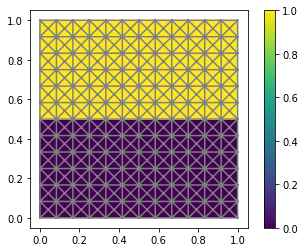

In [141]:
# Define the subdomains by using MeshFunction 
# and marking them with unsigned integers
materials = MeshFunction('size_t', mesh, mesh.topology().dim())
subdomain_0 = UpperDomain()
subdomain_1 = BottomDomain()
subdomain_0.mark(materials, 0)
subdomain_1.mark(materials, 1)
# equivalent:
# materials.set_all(0)
# subdomain_1.mark(materials, 1)
# Mark the interface so that we can apply the Neumann condition at the interface x[1] == 0.5
class MiddleInterface(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.5, 1E-5)
interface = MiddleInterface()
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
interface.mark(boundaries, 0)

plot(mesh); p = plot(materials);  plt.colorbar(p)

In [142]:
# Define the measure dx and ds
dx = Measure("dx", subdomain_data=materials)
ds = Measure("ds", subdomain_data=boundaries)

In [143]:
# Define variational problem

k_0 = 1
k_1 = 0.1

u = TrialFunction(V)
v = TestFunction(V)
f = Expression('x[1] <= 0.5 + tol ? -6*k_0 : -6*k_1',
               degree=2, tol=1E-14, k_0=k_0, k_1=k_1)
a = Constant(k_0)*dot(grad(u), grad(v))*dx(0) + Constant(k_1)*dot(grad(u), grad(v))*dx(1)
L_bcWithInterface = f*v*dx

# Compute solution
u = Function(V)
solve(a == L_bcWithInterface, u, bcWithInterface)

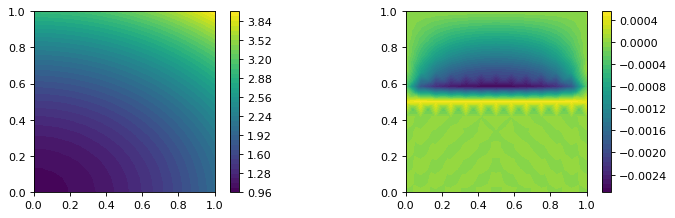

In [144]:
# Plot solution and mesh
plt.figure(figsize=(11, 3), dpi=80)
plt.subplot(1,2,1)
p = plot(u); plt.colorbar(p)

u_e = Expression('1 + pow(x[0], 2) + 2*pow(x[1], 2)', degree=2)
plt.subplot(1,2,2)
p = plot(interpolate(u_e, V) - u); plt.colorbar(p)

# Save solution to file in VTK format
# vtkfile = File('poisson/solution.pvd')
# vtkfile << u

In [145]:
# Compute error in L2 norm
error_L2 = errornorm(u_e, u, 'L2')

# Compute maximum error at verticies
vertex_values_u_D = u_e.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

error_max = np.max(np.abs(vertex_values_u - vertex_values_u_D))

# Print errors
print('error L2 = ', error_L2)
print('error_max = ', error_max)

error L2 =  0.0008210854596477917
error_max =  0.0027746330754343518


In [146]:
g0 = Expression('-k_0', degree=1, k_0=k_0)
g1 = Expression('k_1', degree=1, k_1=k_1)
L_bcWithoutInterface = f*v*dx + Constant(k_0) * g0 * v * ds + Constant(k_1) * g1 * v * ds
w = Function(V)
solve(a == L_bcWithoutInterface, w, bcWithoutInterface)

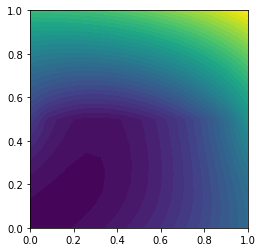

In [147]:
plot(w)